<a href="https://colab.research.google.com/github/pabloruizQC/MSE--1-Hackathon/blob/main/1_MSE_Hackathon_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Here there are four Hackathon problems prepared by Richard (Yu) Liu and Sergei Kalinin.
- Please select **2** out of **4** problems for your in-class "mini-hackathon".

Pablo Ruiz Crespo  pruizcre@vols.utk.edu

William Mason Werner wwerner4@vols.utk.edu


Agnila Surovi asurovi@vols.utk.edu

In [155]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


# Q-1: Interpolating a Sparse Phase Diagram

**Problem description:**

This is a simulated 2D phase diagram: the measured property of (bandgap, coercive field, ionic conductivity, etc.) as a function of parameters (temperature, composition, pressure, etc.).

The property itself is continuous in the phase diagram, but its 1st-derivative is discontinuous at the phase boundaries.

**Tasks:**

1. Using ChatGPT and your domain knowledge, suggest the domain in parameter space over which the function is defined.
2. Using ChatGPT and your domain knowledge, estimate how the function can behave across the parameter space (continuity, extrema, behavior at the edges)
3. Interpolate the property over the full composition space.
4. Compare at least two interpolation methods (e.g., linear, cubic, radial basis).
5. Quantify interpolation uncertainty using cross-validation.
6. Compare uncertainty to the mean square error



## Ground truth for benchmarking and validation.

In [156]:
import numpy as np

# ----------------------------
# Smooth background property P0
# ----------------------------
def P0(x, y):
    """
    Smooth base landscape so the property varies continuously across the whole diagram.
    """
    return (
        1.2
        + 0.9*x
        + 0.7*y
        + 0.25*np.sin(2*np.pi*x)*np.cos(2*np.pi*y)
        + 0.15*np.exp(-((x-0.25)**2 + (y-0.75)**2)/0.02)
    )

# ----------------------------
# Triple-point construction via max of 3 planes
# ----------------------------
def triple_planes(x, y, x0=0.55, y0=0.52, scale=0.9):
    """
    Three affine functions f1,f2,f3 that all equal 0 at (x0,y0).
    Their max partitions the plane into 3 sectors meeting at the triple point.
    """
    u = x - x0
    v = y - y0

    # 3 directions separated by 120 degrees
    a1 = np.array([ 1.0,  0.0])
    a2 = np.array([-0.5,  np.sqrt(3)/2])
    a3 = np.array([-0.5, -np.sqrt(3)/2])

    f1 = scale * (a1[0]*u + a1[1]*v)
    f2 = scale * (a2[0]*u + a2[1]*v)
    f3 = scale * (a3[0]*u + a3[1]*v)
    return f1, f2, f3

def P_ground_truth(x, y, x0=0.55, y0=0.52):
    """
    Continuous property with 3-phase triple point at (x0,y0).
    Gradient is discontinuous across the phase boundaries (where argmax switches).
    """
    f1, f2, f3 = triple_planes(x, y, x0=x0, y0=y0, scale=0.9)

    # max-of-three gives 3 regions with kinked boundaries
    kink = np.maximum.reduce([f1, f2, f3])
    # return kink
    return P0(x, y) + kink

# ----------------------------
# Phase labeling (optional, useful for grading / visualization)
# ----------------------------
def phase_id(x, y, x0=0.55, y0=0.52):
    """
    Returns 0/1/2 indicating which plane wins the max (phase region).
    """
    f1, f2, f3 = triple_planes(x, y, x0=x0, y0=y0, scale=0.9)
    F = np.stack([f1, f2, f3], axis=-1)
    return np.argmax(F, axis=-1)

# ----------------------------
# Random sampling + LogNormal noise
# ----------------------------
def sample_measurements(n=35, sigma_ln=0.15, seed=0, x0=0.55, y0=0.52):
    """
    Random (x,y) ~ Uniform([0,1]^2).
    LogNormal multiplicative noise: P_meas = P_true * LogNormal(0, sigma_ln).
    """
    rng = np.random.default_rng(seed)
    xy = rng.uniform(0.0, 1.0, size=(n, 2))
    x, y = xy[:, 0], xy[:, 1]

    P_true = P_ground_truth(x, y, x0=x0, y0=y0)

    # median 1 multiplicative noise
    noise_factor = rng.lognormal(mean=0.0, sigma=sigma_ln, size=n)
    P_meas = P_true * noise_factor

    return xy, P_true, P_meas

# Example usage:
if __name__ == "__main__":
    xy, P_true, P_meas = sample_measurements(n=35, sigma_ln=0.20, seed=42)
    print("First 5 samples:")
    for i in range(5):
        print(f"(x,y)=({xy[i,0]:.3f},{xy[i,1]:.3f})  true={P_true[i]:.4f}  meas={P_meas[i]:.4f}")


First 5 samples:
(x,y)=(0.774,0.439)  true=2.6345  meas=3.1277
(x,y)=(0.859,0.697)  true=2.8016  meas=2.6965
(x,y)=(0.094,0.976)  true=2.6693  meas=2.0682
(x,y)=(0.761,0.786)  true=2.5693  meas=2.0482
(x,y)=(0.128,0.450)  true=1.7040  meas=1.4177


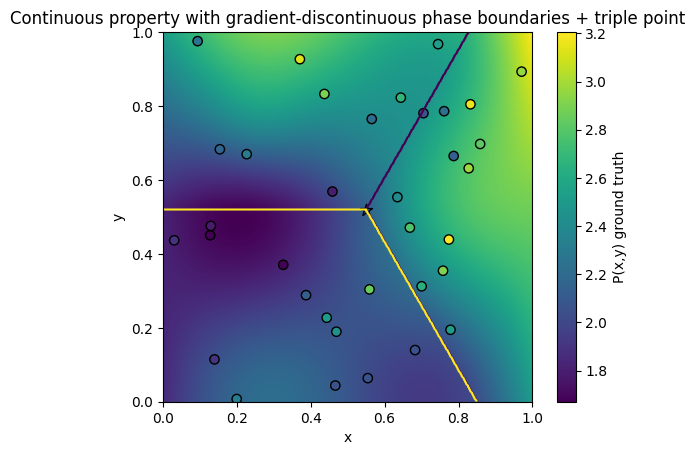

In [157]:
import matplotlib.pyplot as plt

res = 350
xs = np.linspace(0, 1, res)
ys = np.linspace(0, 1, res)
X, Y = np.meshgrid(xs, ys)

Z = P_ground_truth(X, Y, x0=0.55, y0=0.52)
PID = phase_id(X, Y, x0=0.55, y0=0.52)

xy, P_true, P_meas = sample_measurements(n=35, sigma_ln=0.20, seed=42, x0=0.55, y0=0.52)

plt.figure()
plt.imshow(Z, origin="lower", extent=[0,1,0,1], aspect="equal")
plt.colorbar(label="P(x,y) ground truth")

# Phase boundaries are where phase_id changes; contour those boundaries
plt.contour(X, Y, PID, levels=[0.5, 1.5], linewidths=1.5)

# Mark triple point
plt.scatter([0.55], [0.52], s=80, marker="*", edgecolors="k")

# Samples colored by measured value
plt.scatter(xy[:,0], xy[:,1], c=P_meas, edgecolors="k", s=45)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Continuous property with gradient-discontinuous phase boundaries + triple point")
plt.show()


# Q-2: Root-Finding in Nonlinear Constitutive Models

**Problem description:**

A nonlinear stress–strain relation is given implicitly:

$\sigma = E\epsilon + \alpha \cdot \epsilon ^ 3$

where $\sigma$ is the stress, $\epsilon$ is the strain, $E$ is the Young’s modulus (doimnate at small strain), and $\alpha$ is cubic nonlinear term (leading-order elastic nonlinearity).

For typical soft polymers, $E$ $\approx 10^4$ to $10 ^7$ Pa, and $\alpha$ $\approx 10^6$ to $10^8$ Pa

**Tasks:**

1. Given stress values $\sigma$, solve for strain $\epsilon$.
2. Compare Newton, bisection, and secant methods.
3. Identify regimes where Newton fails.




In [158]:
def bisection_method(sigma, epsilon_min, epsilon_max, tol=1e-6, max_iter=100):
    f_min = eq(epsilon_min, sigma)
    f_max = eq(epsilon_max, sigma)

    if f_min * f_max >= 0:
        print("Bisection method fails: Root not bracketed.")
        return None, 0 # Added 0 for iteration count

    for i in range(max_iter):
        epsilon_mid = (epsilon_min + epsilon_max) / 2
        f_mid = eq(epsilon_mid, sigma)

        # Check for convergence
        if abs(f_mid) < tol or (epsilon_max - epsilon_min) < tol:
            return epsilon_mid, i

        # Update brackets
        if f_min * f_mid < 0:
            epsilon_max = epsilon_mid
            f_max = f_mid
        else:
            epsilon_min = epsilon_mid
            f_min = f_mid

    print("Warning: Maximum iterations reached")
    return (epsilon_min + epsilon_max) / 2, max_iter

def secant_method(f, a, b, tol=1e-6, max_iterations=100):
    fa = f(a)
    fb = f(b)

    xprev = xnew = a

    global last_secant_iterations
    last_secant_iterations = 0

    for i in range(max_iterations):
        last_secant_iterations += 1

        # Check to prevent division by zero
        if (fb - fa) == 0:
            print("Secant method fails: Division by zero.")
            return xnew, i

        xprev = xnew
        xnew = a - fa * (b - a) / (fb - fa)
        fnew = f(xnew)

        b = a
        fb = fa
        a = xnew
        fa = fnew

        if abs(xnew - xprev) < tol:
            return xnew, i

    print("Secant method failed to converge to a required precision in " + str(max_iterations) + " iterations")
    print("The error estimate is ", abs(xnew - xprev))
    return xnew, max_iterations

def newton_method(f, df, x0, tol=1e-6, max_iterations=100):
    xprev = xnew = x0

    global last_newton_iterations
    last_newton_iterations = 0

    for i in range(max_iterations):
        last_newton_iterations += 1

        xprev = xnew
        fval = f(xprev)
        dfval = df(xprev)

        if dfval == 0:
            print("Newton method fails: Derivative is zero.")
            return xnew, i

        xnew = xprev - fval / dfval

        if abs(xnew - xprev) < tol:
            return xnew, i

    print("Newton-Raphson method failed to converge to a required precision in " + str(max_iterations) + " iterations")
    print("The error estimate is ", abs(xnew - xprev))

    return xnew, max_iterations

# --- Run the method ---
# Note: Ensure 'eq', 'd_eq' and 'sigma_target' are defined before running this block.

# 1. Bisection handles sigma internally
bisection_strain, bisection_iterations = bisection_method(sigma_target, 0.0, 0.2)

# 2. Secant expects f(x), so we wrap eq(eps, sigma) in a lambda
secant_strain, secant_iterations = secant_method(lambda x: eq(x, sigma_target), 0.0, 0.2)

# 3. Newton expects f(x) and f'(x), so we wrap both in lambdas
newton_strain, newton_iterations = newton_method(
    lambda x: eq(x, sigma_target),
    lambda x: d_eq(x), # Removed sigma_target as d_eq does not accept it
    0.1
)

print(f"Bisection Strain: {bisection_strain}")
print(f"Bisection Iterations: {bisection_iterations}")
print()

print(f"Secant Strain: {secant_strain}")
print(f"Secant Iterations: {secant_iterations}")
print()

print(f"Newton Strain: {newton_strain}")
print(f"Newton Iterations: {newton_iterations}")
print()

Bisection Strain: 0.1515979766845703
Bisection Iterations: 18

Secant Strain: 0.15159802324971203
Secant Iterations: 7

Newton Strain: 0.1515980227692826
Newton Iterations: 4



Newton's method achieves convergence to a root in 4 iterations. It is the fastest method, but it has the potential to fail. Secant method is slower than Newton's method, but is more reliable. Bisection method is the slowest method, but it always works.

For $E > 0$ and $\alpha > 0$, Newton’s method is unconditionally stable, meaning the stress-strain curve is strictly monotonic. I showed for $\alpha < 0$, it creates a local maximum at the curve and at the peak the derivative is zero

# Q-3: Reconstructing a Potential Energy Surface


**Problem description:**

You are given noisy force measurements $F(x)$ sampled sparsely.

**Tasks:**

1. Interpolate F(x).
2. Reconstruct the potential V(x) via numerical integration.
3. Identify equilibrium points and classify stability.
4. Make it by two methods
4. Estimate error vs. ground truth
5. Estimate how error behaves with number of intervals for different methods




In [159]:
# Measured x-array

x = np.array([0.99198791, 1.03401624, 1.09777243, 1.16903863, 1.22400793,
       1.30874129, 1.37720132, 1.58423325, 1.64450453, 1.67796538,
       1.67867585, 1.82164472, 1.83116982, 1.84581047, 1.88011411,
       1.8860672 , 2.06462805, 2.22649524, 2.25211675, 2.3344028 ,
       2.36447286, 2.46400053, 2.49198425, 2.49839337, 2.5253077 ,
       2.53460534, 2.55073504, 2.62779939, 2.63802546, 2.70305563,
       2.77555435, 2.84620648, 2.93177044, 2.93846585, 2.94880694])

In [160]:
# Measured force F(x) with noise added

F = np.array([ 3.49692254e+01,  1.18111393e+01,  1.50752617e+00, -1.47634913e+00,
       -2.69134185e+00, -2.54902098e+00, -2.01257802e+00, -7.32708550e-01,
       -6.94759800e-01, -5.97166382e-01, -6.07822394e-01, -4.05705968e-01,
       -3.44239516e-01, -3.57547192e-01, -2.79683457e-01, -2.86210590e-01,
       -1.65878492e-01, -6.50283631e-02, -7.54397513e-02, -5.71115351e-02,
       -5.05335052e-02, -4.08252108e-02, -5.37775421e-02, -3.29453491e-02,
       -4.41318999e-02, -2.53150113e-02, -3.17176381e-02, -2.84810754e-02,
       -3.01711702e-02, -2.61077932e-02, -2.20682730e-02, -1.47373570e-02,
       -1.17158054e-02, -1.50154447e-02, -1.18781079e-02])

Text(0, 0.5, 'F(x)')

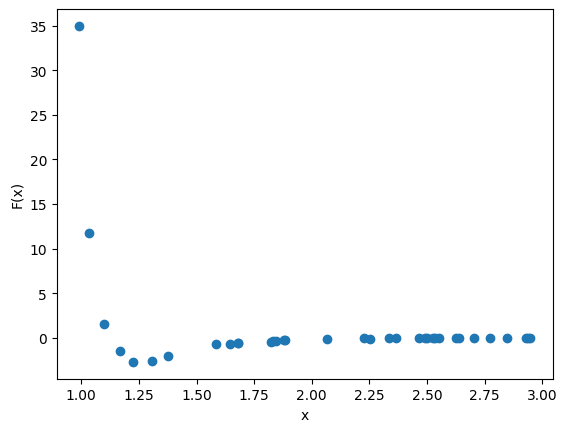

In [161]:
# Visualization

plt.plot(x, F, "o")
plt.xlabel("x")
plt.ylabel("F(x)")

Here is a combination of different parts of the code:


METHOD               | FORCE RMSE   | POTENTIAL RMSE
-------------------------------------------------------
Polynomial           | 805415328.8027       | 48355097.7391
Cubic Spline         | 0.6022       | 0.0691
Linear               | 0.7634       | 0.0485
Smoothing            | 0.5929       | 0.0704


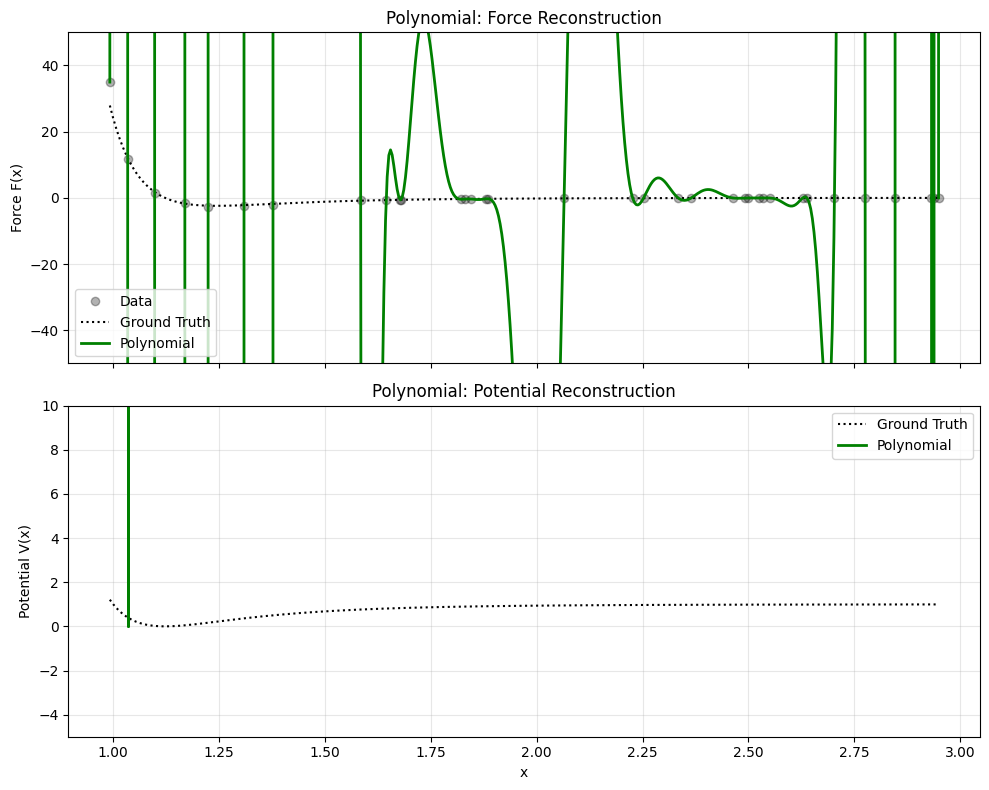

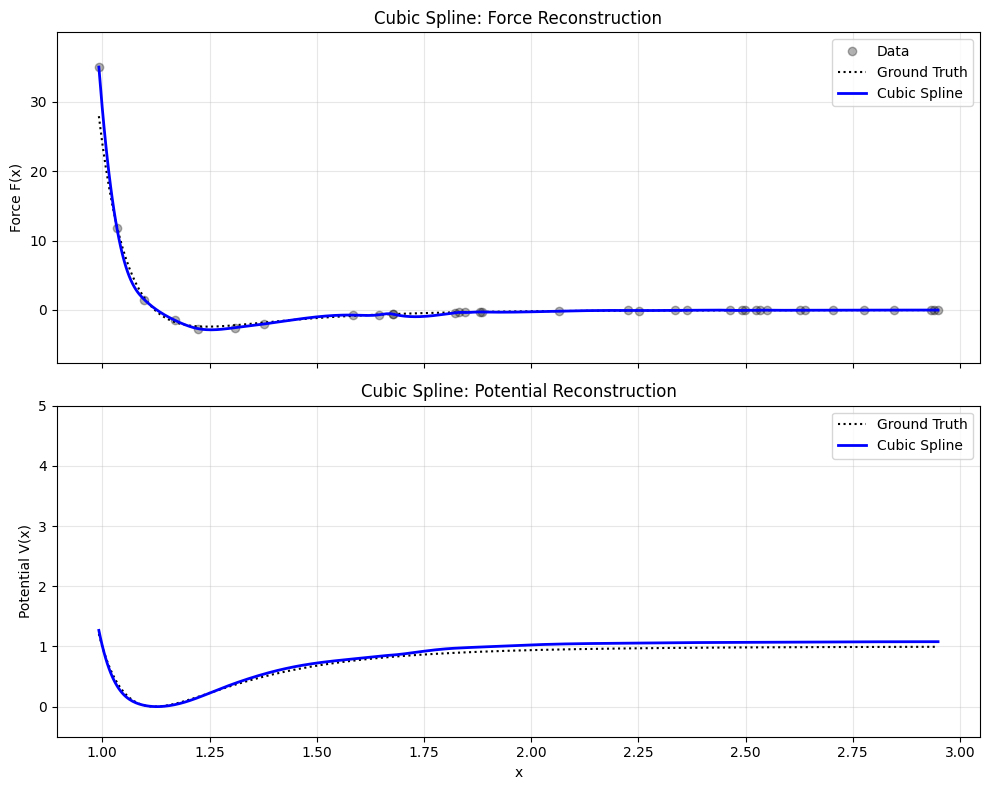

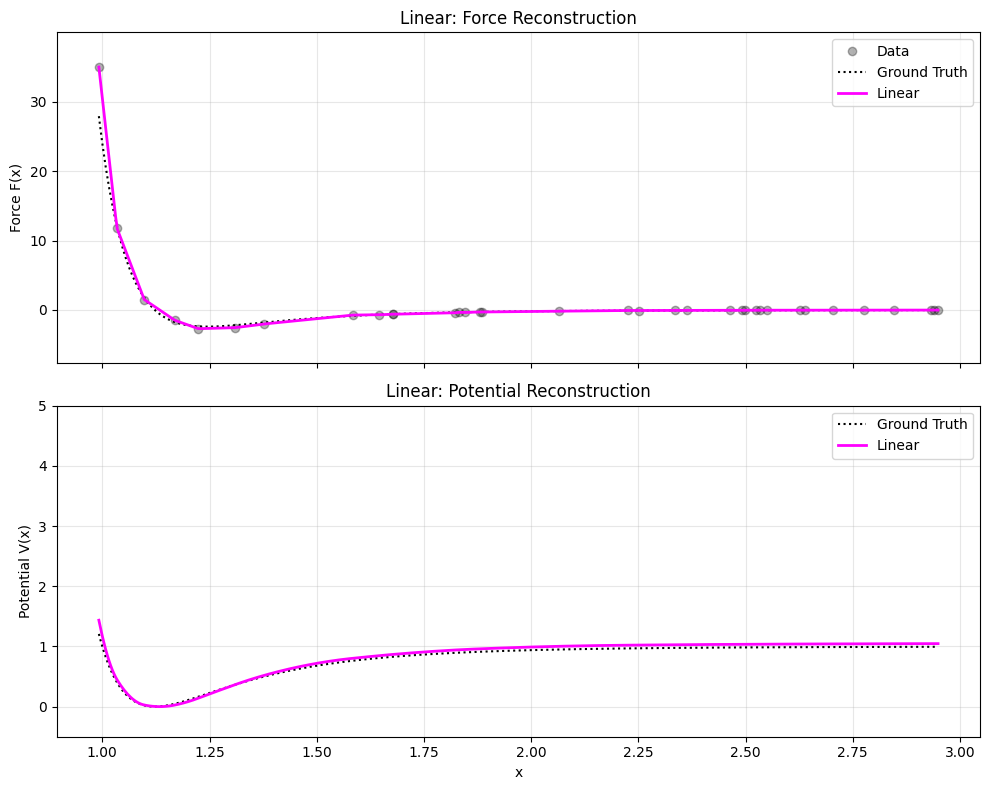

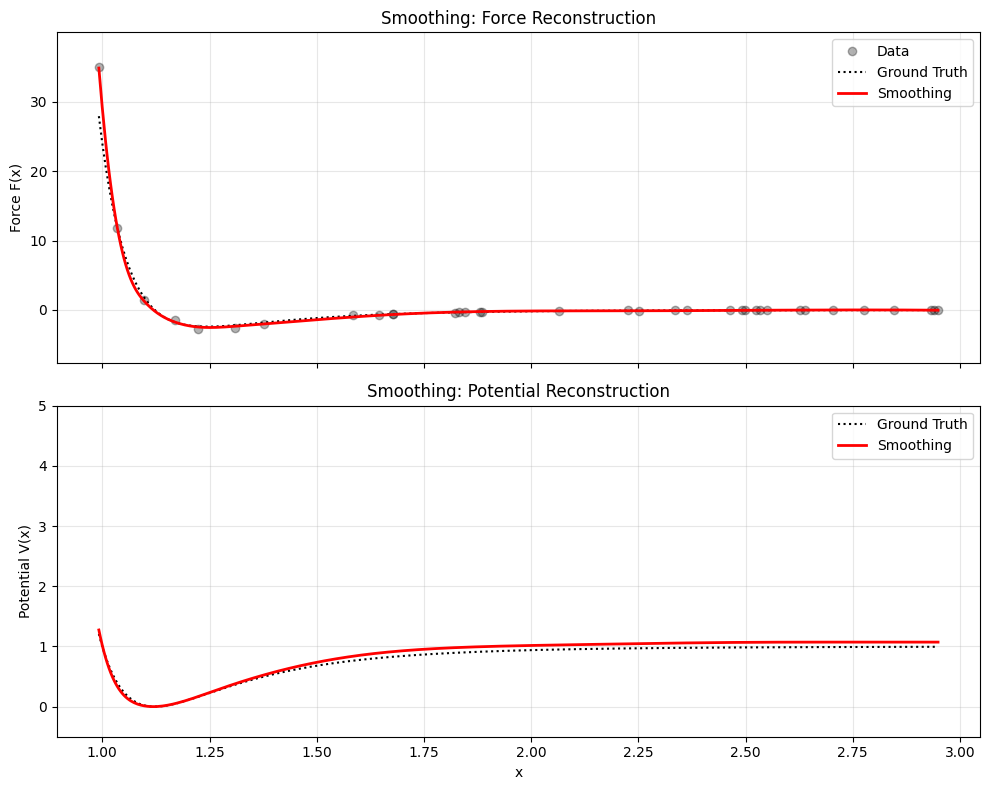


Running Convergence Analysis...


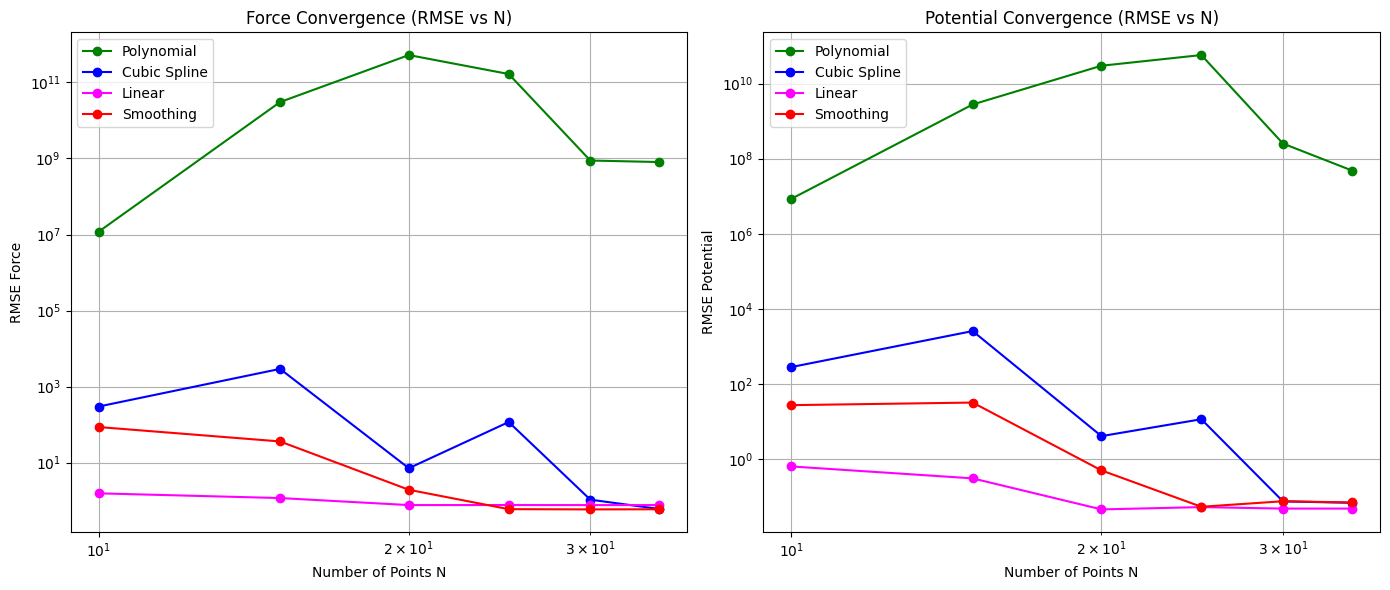

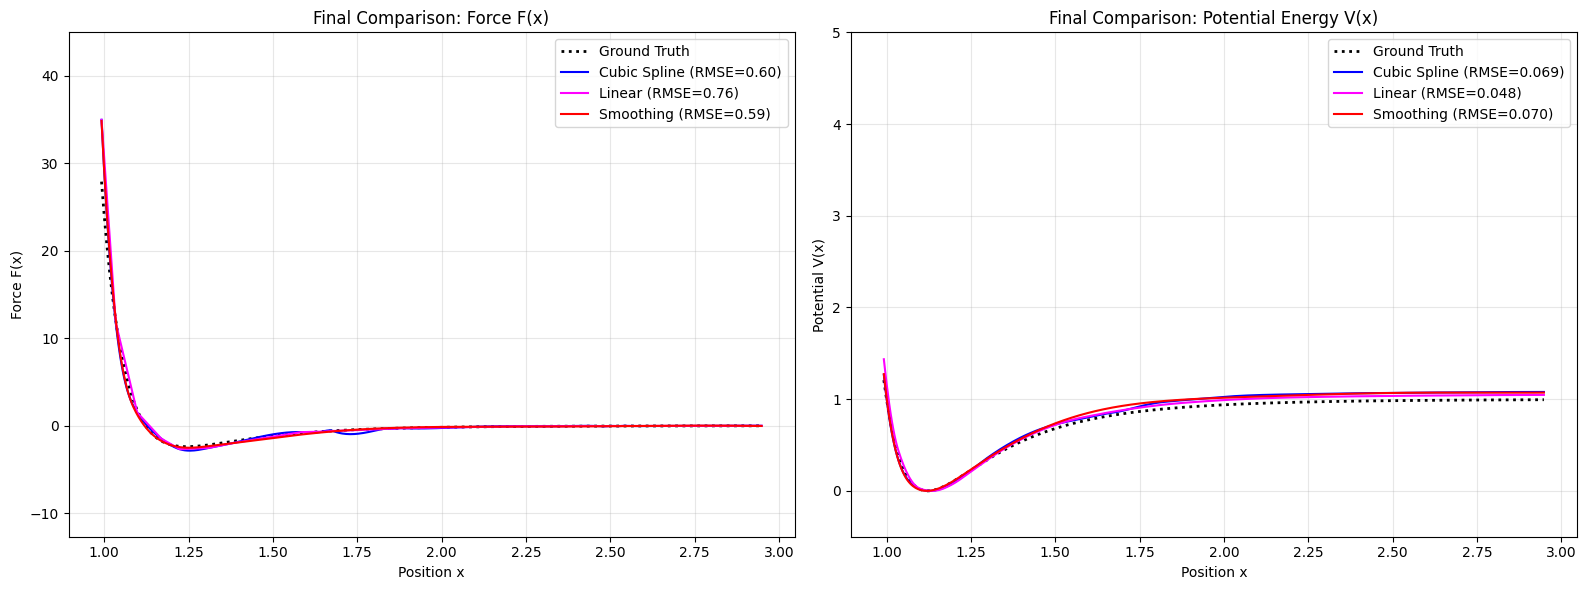


5. EQUILIBRIUM & STABILITY ANALYSIS (Comparing All Methods)

Method: Polynomial
------------------------------
  x = 1.0341 : Stable (Minimum)
  x = 1.0978 : Unstable (Maximum)
  x = 1.1691 : Stable (Minimum)
  x = 1.2240 : Unstable (Maximum)
  x = 1.3088 : Stable (Minimum)
  x = 1.3772 : Unstable (Maximum)
  x = 1.5843 : Stable (Minimum)
  x = 1.6450 : Unstable (Maximum)
  x = 1.6755 : Stable (Minimum)
  x = 1.6815 : Unstable (Maximum)
  x = 1.8110 : Stable (Minimum)
  x = 2.0647 : Unstable (Maximum)
  x = 2.2265 : Stable (Minimum)
  x = 2.2524 : Unstable (Maximum)
  x = 2.3339 : Stable (Minimum)
  x = 2.3651 : Unstable (Maximum)
  x = 2.4618 : Stable (Minimum)
  x = 2.6283 : Unstable (Maximum)
  x = 2.6373 : Stable (Minimum)
  x = 2.7029 : Unstable (Maximum)
  x = 2.7755 : Stable (Minimum)
  x = 2.8461 : Unstable (Maximum)
  x = 2.9322 : Stable (Minimum)
  x = 2.9381 : Unstable (Maximum)
  x = 2.9488 : Stable (Minimum)

Method: Cubic Spline
------------------------------
  x = 1.127

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, interp1d, CubicSpline
from scipy.integrate import cumulative_trapezoid

# ==========================================
# 1. GROUND TRUTH & DATA SETUP
# ==========================================
def lj_potential(r, epsilon=1.0, sigma=1.0):
    """ Ground Truth Potential: V(r) """
    sr6 = (sigma / r) ** 6
    return 4.0 * epsilon * (sr6**2 - sr6)

def lj_force(r, epsilon=1.0, sigma=1.0):
    """ Ground Truth Force: F(r) """
    sr6 = (sigma / r) ** 6
    sr12 = sr6**2
    return 24.0 * epsilon / r * (2.0 * sr12 - sr6)

# Data from assignment
x = np.array([0.99198791, 1.03401624, 1.09777243, 1.16903863, 1.22400793, 1.30874129, 1.37720132, 1.58423325, 1.64450453, 1.67796538, 1.67867585, 1.82164472, 1.83116982, 1.84581047, 1.88011411, 1.8860672, 2.06462805, 2.22649524, 2.25211675, 2.3344028, 2.36447286, 2.46400053, 2.49198425, 2.49839337, 2.5253077, 2.53460534, 2.55073504, 2.62779939, 2.63802546, 2.70305563, 2.77555435, 2.84620648, 2.93177044, 2.93846585, 2.94880694])
F = np.array([3.49692254e+01, 1.18111393e+01, 1.50752617e+00, -1.47634913e+00, -2.69134185e+00, -2.54902098e+00, -2.01257802e+00, -7.32708550e-01, -6.94759800e-01, -5.97166382e-01, -6.07822394e-01, -4.05705968e-01, -3.44239516e-01, -3.57547192e-01, -2.79683457e-01, -2.86210590e-01, -1.65878492e-01, -6.50283631e-02, -7.54397513e-02, -5.71115351e-02, -5.05335052e-02, -4.08252108e-02, -5.37775421e-02, -3.29453491e-02, -4.41318999e-02, -2.53150113e-02, -3.17176381e-02, -2.84810754e-02, -3.01711702e-02, -2.61077932e-02, -2.20682730e-02, -1.47373570e-02, -1.17158054e-02, -1.50154447e-02, -1.18781079e-02])

# Sort Data
idx = np.argsort(x)
x, F = x[idx], F[idx]

# Fine grid for plotting and error calc
x_fine = np.linspace(x.min(), x.max(), 500)
V_true_fine = lj_potential(x_fine)
V_true_fine -= V_true_fine.min() # Normalize Ground Truth
F_true_fine = lj_force(x_fine)

# ==========================================
# 2. HELPER FUNCTIONS FOR METHODS
# ==========================================

def run_polynomial(x_in, F_in, x_eval):
    # --- Teammate's Exact Code Start ---
    def lagrange_basis_j(pt, j, x_vals):
        l = 1.
        for k in x_vals:
            if k != j:
                l *= (pt - k) / (j - k)
        return l

    def polynomial_interpolation_result(pt, x_vals, y_vals):
        fx = 0.
        for i, j in enumerate(x_vals):
            fx += y_vals[i] * lagrange_basis_j(pt, j, x_vals)
        return fx
    # --- Teammate's Exact Code End ---

    # Execute Teammate's function for every point in x_eval
    # Note: This loop can be slow because it recalculates basis functions for every point
    F_est = np.array([polynomial_interpolation_result(val, x_in, F_in) for val in x_eval])

    # Integrate to find Potential
    V_est = -cumulative_trapezoid(F_est, x_eval, initial=0)
    V_est -= V_est.min()
    return F_est, V_est

def run_cubic_spline(x_in, F_in, x_eval):
    cs = CubicSpline(x_in, F_in)
    F_est = cs(x_eval)
    V_est = -cs.antiderivative()(x_eval)
    V_est -= V_est.min()
    return F_est, V_est

def run_linear(x_in, F_in, x_eval):
    lin = interp1d(x_in, F_in, kind='linear', fill_value="extrapolate")
    F_est = lin(x_eval)
    V_est = -cumulative_trapezoid(F_est, x_eval, initial=0)
    V_est -= V_est.min()
    return F_est, V_est

def run_smoothing_spline(x_in, F_in, x_eval, s=0.5):
    ss = UnivariateSpline(x_in, F_in, s=s)
    F_est = ss(x_eval)
    V_func = ss.antiderivative()
    V_est = -V_func(x_eval)
    V_est -= V_est.min()
    return F_est, V_est

# ==========================================
# 3. RUN ANALYSIS ON FULL DATASET
# ==========================================

# 1. Polynomial
F_poly, V_poly = run_polynomial(x, F, x_fine)

# 2. Cubic Spline
F_cubic, V_cubic = run_cubic_spline(x, F, x_fine)

# 3. Linear
F_linear, V_linear = run_linear(x, F, x_fine)

# 4. Smoothing Spline
F_smooth, V_smooth = run_smoothing_spline(x, F, x_fine)

# RMSE Calculation
def get_rmse(est, true):
    return np.sqrt(np.mean((est - true)**2))

methods = {
    "Polynomial": (F_poly, V_poly, 'green'),
    "Cubic Spline": (F_cubic, V_cubic, 'blue'),
    "Linear": (F_linear, V_linear, 'magenta'),
    "Smoothing": (F_smooth, V_smooth, 'red')
}

print(f"{'METHOD':<20} | {'FORCE RMSE':<12} | {'POTENTIAL RMSE':<12}")
print("-" * 55)
for name, (f_est, v_est, _) in methods.items():
    rmse_f = get_rmse(f_est, F_true_fine)
    rmse_v = get_rmse(v_est, V_true_fine)
    print(f"{name:<20} | {rmse_f:.4f}       | {rmse_v:.4f}")

# ==========================================
# 4. INDIVIDUAL PLOTS (FORCE + POTENTIAL)
# ==========================================

for name, (F_est, V_est, color) in methods.items():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Force Plot
    ax1.plot(x, F, 'ko', alpha=0.3, label='Data')
    ax1.plot(x_fine, F_true_fine, 'k:', label='Ground Truth')
    ax1.plot(x_fine, F_est, color=color, linewidth=2, label=f'{name}')
    ax1.set_title(f'{name}: Force Reconstruction')
    ax1.set_ylabel('Force F(x)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Scale adjustment for polynomial
    if name == "Polynomial":
        ax1.set_ylim(-50, 50)
    else:
        ax1.set_ylim(min(F)-5, max(F)+5)

    # Potential Plot
    ax2.plot(x_fine, V_true_fine, 'k:', label='Ground Truth')
    ax2.plot(x_fine, V_est, color=color, linewidth=2, label=f'{name}')
    ax2.set_title(f'{name}: Potential Reconstruction')
    ax2.set_ylabel('Potential V(x)')
    ax2.set_xlabel('x')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    if name == "Polynomial":
        ax2.set_ylim(-5, 10)
    else:
        ax2.set_ylim(-0.5, 5)

    plt.tight_layout()
    plt.show()


# ==========================================
# 5. CONVERGENCE ANALYSIS (Loop N points)
# ==========================================

n_points_range = [10, 15, 20, 25, 30, 35]
convergence_results = {key: {'F': [], 'V': []} for key in methods.keys()}

print("\nRunning Convergence Analysis...")

for n in n_points_range:
    # Sub-sample data
    x_sub, F_sub = x[:n], F[:n]

    # 1. Poly
    f_p, v_p = run_polynomial(x_sub, F_sub, x_fine)
    convergence_results['Polynomial']['F'].append(get_rmse(f_p, F_true_fine))
    convergence_results['Polynomial']['V'].append(get_rmse(v_p, V_true_fine))

    # 2. Cubic
    f_c, v_c = run_cubic_spline(x_sub, F_sub, x_fine)
    convergence_results['Cubic Spline']['F'].append(get_rmse(f_c, F_true_fine))
    convergence_results['Cubic Spline']['V'].append(get_rmse(v_c, V_true_fine))

    # 3. Linear
    f_l, v_l = run_linear(x_sub, F_sub, x_fine)
    convergence_results['Linear']['F'].append(get_rmse(f_l, F_true_fine))
    convergence_results['Linear']['V'].append(get_rmse(v_l, V_true_fine))

    # 4. Smoothing
    f_s, v_s = run_smoothing_spline(x_sub, F_sub, x_fine)
    convergence_results['Smoothing']['F'].append(get_rmse(f_s, F_true_fine))
    convergence_results['Smoothing']['V'].append(get_rmse(v_s, V_true_fine))

# ==========================================
# 6. CONVERGENCE PLOTS
# ==========================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for name, data in convergence_results.items():
    color = methods[name][2]
    ax1.loglog(n_points_range, data['F'], marker='o', linestyle='-', color=color, label=name)
    ax2.loglog(n_points_range, data['V'], marker='o', linestyle='-', color=color, label=name)

ax1.set_title("Force Convergence (RMSE vs N)")
ax1.set_xlabel("Number of Points N")
ax1.set_ylabel("RMSE Force")
ax1.legend()
ax1.grid(True, which="both")

ax2.set_title("Potential Convergence (RMSE vs N)")
ax2.set_xlabel("Number of Points N")
ax2.set_ylabel("RMSE Potential")
ax2.legend()
ax2.grid(True, which="both")

plt.tight_layout()
plt.show()

# ==========================================
# 7. FINAL COMBINED COMPARISON
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Force Comparison
ax1.set_title("Final Comparison: Force F(x)")
ax1.plot(x_fine, F_true_fine, 'k:', linewidth=2, label='Ground Truth')

for name, (F_est, _, color) in methods.items():
    rmse = get_rmse(F_est, F_true_fine)
    # Hide Polynomial if it's too unstable to see the others
    if name == "Polynomial" and rmse > 20:
        continue
    ax1.plot(x_fine, F_est, color=color, label=f'{name} (RMSE={rmse:.2f})')

ax1.set_ylim(min(F)-10, max(F)+10)
ax1.set_ylabel("Force F(x)")
ax1.set_xlabel("Position x")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Potential Comparison
ax2.set_title("Final Comparison: Potential Energy V(x)")
ax2.plot(x_fine, V_true_fine, 'k:', linewidth=2, label='Ground Truth')

for name, (_, V_est, color) in methods.items():
    rmse = get_rmse(V_est, V_true_fine)
    if name == "Polynomial" and rmse > 10:
        continue
    ax2.plot(x_fine, V_est, color=color, label=f'{name} (RMSE={rmse:.3f})')

ax2.set_ylim(-0.5, 5)
ax2.set_ylabel("Potential V(x)")
ax2.set_xlabel("Position x")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#
# EQUILIBRIUM & STABILITY (ALL METHODS)

print("\n" + "="*60)
print("5. EQUILIBRIUM & STABILITY ANALYSIS (Comparing All Methods)")
print("="*60)

for name, (F_est, _, _) in methods.items():
    print(f"\nMethod: {name}")
    print("-" * 30)

    # 1. Find indices where Force changes sign (crosses zero)
    # np.signbit returns True for negative, False for positive
    # np.diff checks for changes between consecutive points
    sign_changes = np.where(np.diff(np.signbit(F_est)))[0]

    found_points = False
    for idx in sign_changes:
        # 2. Linear Interpolation for precise x location
        # We know the zero crossing is between idx and idx+1
        x1, x2 = x_fine[idx], x_fine[idx+1]
        y1, y2 = F_est[idx], F_est[idx+1]

        # Formula for x where y=0 between two points
        if (y2 - y1) != 0:
            root_x = x1 - y1 * (x2 - x1) / (y2 - y1)
        else:
            root_x = x1

        # 3. Determine Stability
        # Calculate slope (dF/dx) at the crossing
        slope = (y2 - y1) / (x2 - x1)

        # Physics Rule:
        # Slope < 0 --> Restoring Force --> Stable Equilibrium (Potential Minimum)
        # Slope > 0 --> Repulsive Force --> Unstable Equilibrium (Potential Maximum)
        stability = "Stable (Minimum)" if slope < 0 else "Unstable (Maximum)"

        # Filter out phantom roots at the very edges of interpolation
        if x.min() < root_x < x.max():
            print(f"  x = {root_x:.4f} : {stability}")
            found_points = True

    if not found_points:
        print("  No equilibrium points found in valid range.")




## Ground-truth for benchmarking and validation

In [163]:
import numpy as np

# ----------------------------
# Lennard–Jones potential + force (ground truth)
# ----------------------------
def lj_potential(r, epsilon=1.0, sigma=1.0):
    """
    V(r) = 4ε[(σ/r)^12 - (σ/r)^6]
    r must be > 0.
    """
    sr6 = (sigma / r) ** 6
    return 4.0 * epsilon * (sr6**2 - sr6)

def lj_force(r, epsilon=1.0, sigma=1.0):
    """
    Force is negative derivative of potential:
      F(r) = -dV/dr = 24ε/r [2(σ/r)^12 - (σ/r)^6]
    Convention: positive F means repulsive (pushing outward).
    """
    sr6 = (sigma / r) ** 6
    sr12 = sr6**2
    return 24.0 * epsilon / r * (2.0 * sr12 - sr6)

# ----------------------------
# Sampling with LogNormal noise
# ----------------------------
def sample_noisy_lj_force(
    n=35,
    r_min=0.9, r_max=3.0,
    epsilon=1.0, sigma=1.0,
    sigma_ln=0.15,
    seed=0
):
    """
    Sample n separations r uniformly in [r_min, r_max].
    Compute ground truth V(r), F(r).
    Add multiplicative LogNormal noise to |F| while preserving sign:
        F_meas = sign(F_true) * |F_true| * LogNormal(0, sigma_ln)

    This avoids sign flips caused by multiplicative noise near zero.
    """
    rng = np.random.default_rng(seed)

    r = rng.uniform(r_min, r_max, size=n)
    r.sort()

    V_true = lj_potential(r, epsilon=epsilon, sigma=sigma)
    F_true = lj_force(r, epsilon=epsilon, sigma=sigma)

    # multiplicative noise factor (median 1)
    noise_factor = rng.lognormal(mean=0.0, sigma=sigma_ln, size=n)

    # apply to magnitude, keep sign
    F_meas = np.sign(F_true) * (np.abs(F_true) * noise_factor)

    return r, V_true, F_true, F_meas

# ----------------------------
# Optional: dense ground-truth curve for plotting / grading
# ----------------------------
def dense_ground_truth(
    r_min=0.9, r_max=3.0, num=800,
    epsilon=1.0, sigma=1.0
):
    r = np.linspace(r_min, r_max, num=num)
    V = lj_potential(r, epsilon=epsilon, sigma=sigma)
    F = lj_force(r, epsilon=epsilon, sigma=sigma)
    return r, V, F

# Example usage:
if __name__ == "__main__":
    eps, sig = 1.0, 1.0
    r_s, V_s, F_true_s, F_meas_s = sample_noisy_lj_force(
        n=35, r_min=0.9, r_max=3.0,
        epsilon=eps, sigma=sig,
        sigma_ln=0.20, seed=42
    )

    print("First 5 sparse samples:")
    for i in range(5):
        print(f"r={r_s[i]:.4f}  V_true={V_s[i]: .5f}  F_true={F_true_s[i]: .5f}  F_meas={F_meas_s[i]: .5f}")

    # Dense ground truth arrays (for plotting / reference)
    r_dense, V_dense, F_dense = dense_ground_truth(
        r_min=0.9, r_max=3.0, num=800,
        epsilon=eps, sigma=sig
    )


First 5 sparse samples:
r=0.9920  V_true= 0.20758  F_true= 27.90132  F_meas= 34.96923
r=1.0340  V_true=-0.59511  F_true= 12.08340  F_meas= 11.81114
r=1.0978  V_true=-0.97962  F_true= 1.78336  F_meas= 1.50753
r=1.1690  V_true=-0.95314  F_true=-1.74102  F_meas=-1.47635
r=1.2240  V_true=-0.83576  F_true=-2.36297  F_meas=-2.69134


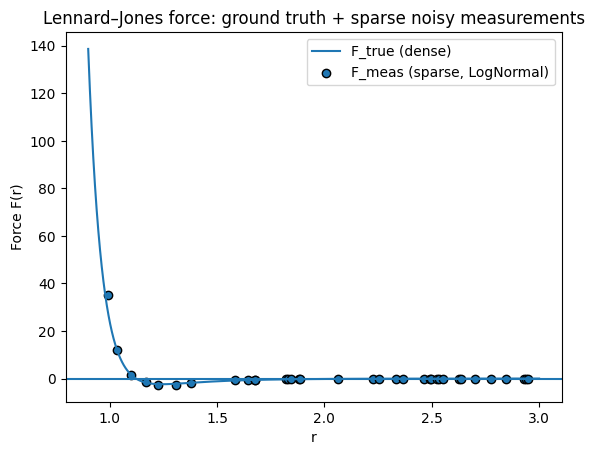

In [164]:
import matplotlib.pyplot as plt

eps, sig = 1.0, 1.0
r_s, V_s, F_true_s, F_meas_s = sample_noisy_lj_force(
    n=35, r_min=0.9, r_max=3.0,
    epsilon=eps, sigma=sig,
    sigma_ln=0.20, seed=42
)
r_dense, V_dense, F_dense = dense_ground_truth(
    r_min=0.9, r_max=3.0, num=800,
    epsilon=eps, sigma=sig
)

plt.figure()
plt.plot(r_dense, F_dense, label="F_true (dense)")
plt.scatter(r_s, F_meas_s, label="F_meas (sparse, LogNormal)", edgecolors="k")
plt.axhline(0.0)
plt.xlabel("r")
plt.ylabel("Force F(r)")
plt.legend()
plt.title("Lennard–Jones force: ground truth + sparse noisy measurements")
plt.show()


# Q-4: Inferring a Hidden Parameter


**Problem description:**

A measurement depends on an unknown parameter $\theta$:

$y(x) = sin(\theta x)\cdot \exp(-x/\theta) + 0.1$

**Tasks:**

1. Analyze the model function and explain how the parameter $\theta$ affects: the oscillation frequency, the decay rate, and the overall signal shape.
2. Interpolate experimental $y(x)$.
3. Use root finding or optimization to infer $\theta$ as a function of control parameter
4. Assess sensitivity to sampling density: calculate the erro vs, number of sampling point





## Ground-truth for comparison

In [165]:
import numpy as np

# ----------------------------
# Ground-truth model
# ----------------------------
def model_y(x, theta):
    return np.sin(theta * x) * np.exp(-x / theta) + 0.1

# ----------------------------
# Data generation
# ----------------------------
def generate_data(
    theta=3.14,
    n_samples=20,
    x_min=0.0,
    x_max=6.0,
    noise_sigma=0.0,
    seed=0
):
    """
    Generate randomly sampled measurements y(x).

    Parameters
    ----------
    theta : float
        True hidden parameter.
    n_samples : int
        Number of sampling points.
    x_min, x_max : float
        Measurement range.
    noise_sigma : float
        Std dev of additive Gaussian noise (0 = noise-free).
    seed : int
        RNG seed.

    Returns
    -------
    x : ndarray
        Sampled x locations (sorted).
    y_true : ndarray
        Noise-free ground truth values.
    y_meas : ndarray
        Measured values (with noise).
    """
    rng = np.random.default_rng(seed)

    # Random sampling in x
    x = rng.uniform(x_min, x_max, size=n_samples)
    x.sort()

    # Ground truth
    y_true = model_y(x, theta)

    # Optional additive noise
    noise = rng.normal(0.0, noise_sigma, size=n_samples)
    y_meas = y_true + noise

    return x, y_true, y_meas

# ----------------------------
# Example usage
# ----------------------------
if __name__ == "__main__":
    x, y_true, y_meas = generate_data(
        theta=3.14,
        n_samples=20,
        x_min=0.0,
        x_max=6.0,
        noise_sigma=0.1,
        seed=42
    )

    print("First 5 samples:")
    for i in range(5):
        print(f"x = {x[i]:.3f}, y_true = {y_true[i]:.4f}, y_meas = {y_meas[i]:.4f}")


First 5 samples:
x = 0.383, y_true = 0.9258, y_meas = 0.9073
x = 0.565, y_true = 0.9181, y_meas = 0.8500
x = 0.769, y_true = 0.6209, y_meas = 0.7431
x = 1.363, y_true = -0.4885, y_meas = -0.5039
x = 2.225, y_true = 0.4182, y_meas = 0.3754


In [166]:
def dense_ground_truth(theta=3.14, x_min=0.0, x_max=6.0, n=1000):
    x = np.linspace(x_min, x_max, n)
    y = model_y(x, theta)
    return x, y


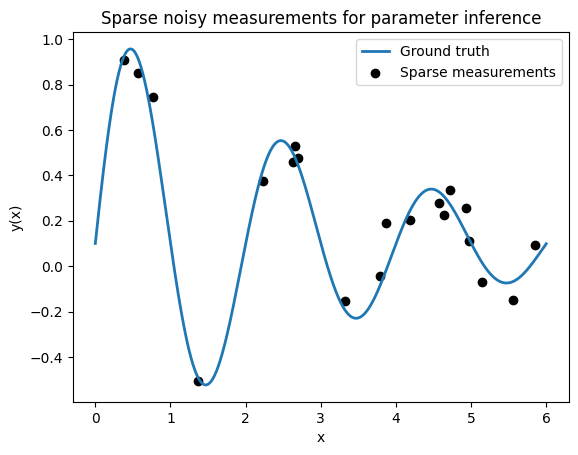

In [167]:
import matplotlib.pyplot as plt

x_s, y_true_s, y_meas_s = generate_data(
    theta=3.14, n_samples=20, noise_sigma=0.1, seed=42
)
x_dense, y_dense = dense_ground_truth(theta=3.14)

plt.figure()
plt.plot(x_dense, y_dense, label="Ground truth", lw=2)
plt.scatter(x_s, y_meas_s, c="k", label="Sparse measurements")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.legend()
plt.title("Sparse noisy measurements for parameter inference")
plt.show()
